In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *

from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid, qmc_quad

import sys
from os.path import isfile
import jax
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'cpu')




Lambda_idx = 24#int(sys.argv[1])
n_bins = 100#int(sys.argv[2])

idx1 = 0#int(sys.argv[3])
idx2 = 0#int(sys.argv[4])

Lambda = Lambdas[Lambda_idx]

zmin = 2.4#float(sys.argv[5])
zmax = 3.4#float(sys.argv[6])

kernels = {}
kernels['CII'] = np.array(KI)
kernels['CO'] = np.array(KI_CO)
kernels['Lya'] = np.array(KI_Lya)
kernels['HI'] = np.array(KI_HI)


line_str = 'CO'#sys.argv[7]
print(line_str)
_KI = kernels[line_str]

oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/lolo_'
oup_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_%d_%d_jax_quad.npy'%(line_str,
                                                                                zmin, zmax, 
                                                                                Lambda_idx, 
                                                                                n_bins,idx1, idx2)


print(oup_fname)

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
inner_dkparp_integral = inner_dkparp_integral.astype(np.float64)
inner_dkparp_integral = np.moveaxis(inner_dkparp_integral, 0, -1)

@jax.jit
def f_KILo(chi, external_chi, Lambda):
    return (Lambda / jnp.pi 
            * jnp.interp(x = chi, xp = chis, 
                         fp = _KI, left = 0, right = 0) 
            * jnp.sinc(Lambda * (external_chi - chi) / np.pi))


CO
/scratch/users/delon/LIMxCMBL/I_auto/lolo_CO_zmin_2.4_zmax_3.4_Lambda_idx_24_n_b_100_0_0_jax_quad.npy


In [2]:
inner_dkparp_integral.shape

(256, 128, 100)

In [3]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [4]:
from interpax import interp2d
from interpax import interp1d as interp1dx

from tqdm import trange, tqdm

In [5]:
@jax.jit
def f_integrand(x):
    chi, chip, _chib = x[0], x[1], x[2]
    chi = chi.reshape(-1, 1)
    chip = chip.reshape(-1, 1)
    _chib = _chib.reshape(-1, 1)    
    #LoLo
    plus = _chib*(1+deltas.reshape(1, -1))
    mins = _chib*(1-deltas.reshape(1, -1))
    _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)
    LoLo_integrand  = jnp.where(_idxs,
                               f_KILo(plus, 
                                      external_chi = chi,
                                      Lambda=Lambda) 
                                * f_KILo(mins, 
                                         external_chi = chip,
                                         Lambda=Lambda),
                               0)

    LoLo_integrand += jnp.where(_idxs,
                               f_KILo(mins, 
                                      external_chi = chi,
                                      Lambda=Lambda) 
                                * f_KILo(plus, 
                                         external_chi = chip,
                                         Lambda=Lambda),0)
    LoLo_integrand *= (2 / _chib) * deltas.reshape(1, -1)
    LoLo_integrand = jnp.einsum('pd, pdl->pld', LoLo_integrand,
                                interp1dx(xq = _chib.reshape(-1),x = chibs, 
                                f=inner_dkparp_integral,
                                method='linear',))

    LoLo_integrand = jnp.trapezoid(x = np.log(deltas), y = LoLo_integrand, axis=-1)
    return LoLo_integrand

In [6]:
from scipy.stats import qmc
qrng = qmc.Halton(d = 3)


In [7]:
l1, r1 = chi_bin_edges[idx1], chi_bin_edges[idx1+1]
l2, r2 = chi_bin_edges[idx2], chi_bin_edges[idx2+1]


In [8]:
def _rng_spawn(rng, n_children):
    bg = rng._bit_generator
    ss = bg._seed_seq
    child_rngs = [np.random.Generator(type(bg)(child_ss))
                  for child_ss in ss.spawn(n_children)]
    return child_rngs

In [10]:

n_estimates = 2**3
n_points = 2**16
estimates = np.zeros((n_estimates, 100))


rngs = _rng_spawn(qrng.rng, n_estimates)



for i in trange(n_estimates):
    sample = qrng.random(n = n_points)

    def _curr(a, b):
        A = np.prod(b - a)
        dA = A / n_points

        x = jnp.array(qmc.scale(sample, a, b)).T
        return np.sum(f_integrand(x) * dA, axis = 0)
        
    for (l3, r3) in [(10, chimin), (chimin, chimax), (chimax, chimax_sample)]:
        a = np.array([l1, l2, l3, ])
        b = np.array([r1, r2, r3, ])
        estimates[i] += _curr(a,b)
    qrng = type(qrng)(seed=rngs[i], **qrng._init_quad)
    
integral = np.mean(estimates, axis=0)
standard_error = np.std(estimates, axis = 0, ddof = 1)

100%|██████████| 8/8 [00:49<00:00,  6.22s/it]


In [11]:
np.save(oup_fname, integral/dchi_binned**2)
np.save(oup_fname + 'relerr', standard_error/integral)

print(standard_error/integral)

[0.00040088 0.00040119 0.00040154 0.0004019  0.00040229 0.00040271
 0.00040315 0.00040362 0.00040411 0.00040463 0.00040517 0.00040573
 0.00040631 0.00040691 0.00040752 0.00040813 0.00040875 0.00040937
 0.00040997 0.00041054 0.00041109 0.00041158 0.00041202 0.00041237
 0.00041264 0.00041279 0.0004128  0.00041265 0.00041232 0.00041177
 0.00041098 0.00040993 0.00040857 0.00040689 0.00040486 0.00040245
 0.00039966 0.00039648 0.00039292 0.00038901 0.00038479 0.00038034
 0.00037574 0.00037112 0.0003666  0.00036237 0.00035853 0.00035516
 0.00035226 0.00034975 0.00034749 0.00034516 0.00034222 0.00033825
 0.00033284 0.00032584 0.00031749 0.00030848 0.00029993 0.00029309
 0.00028873 0.00028657 0.00028521 0.00028245 0.00027657 0.00026822
 0.00026    0.000255   0.00025376 0.00025313 0.00024948 0.00024297
 0.00023795 0.00023675 0.00023615 0.00023308 0.00022995 0.00022927
 0.00022885 0.00022758 0.00022737 0.00022786 0.00022822 0.00022925
 0.00023065 0.00023231 0.00023444 0.00023682 0.00023957 0.0002

In [12]:
import matplotlib.pyplot as plt

In [13]:
cross_fname = '/scratch/users/delon/LIMxCMBL/I_auto/cross_'
cross_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_%d_%d_jax_quad.npy'%(line_str,
                                                                                zmin, zmax, 
                                                                                Lambda_idx, 
                                                                                n_bins,idx1, idx2)

cross = np.load(cross_fname)

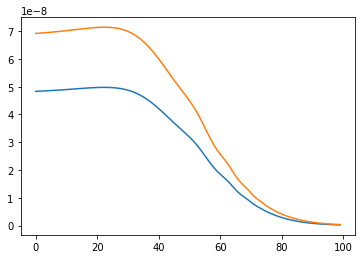

In [14]:
plt.plot(integral/dchi_binned**2)
plt.plot(cross)

In [17]:
def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
    
    oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            oup[:,i,j] = (np.sum(base[:,
                                      idx1[0]:idx1[-1]+1,
                                      idx2[0]:idx2[-1]+1], 
                                 axis=(1, 2)) / len(idx1) / len(idx2))
    return oup

In [40]:
comb_n_external = 101
comb_unbinned = np.zeros((len(ells), comb_n_external, comb_n_external))
for ell_idx in range(len(ells)):
    comb_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
    comb_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_l_%d_jax_quad.npy'%('CO',
                                                                                  zmin, zmax, 
                                                                                  Lambda_idx, 
                                                                                  comb_n_external,
                                                                                  ell_idx)


    comb_unbinned[ell_idx] = np.load(comb_fname)

comb = get_binned(comb_unbinned, n_external = comb_n_external)


(-1.2e-07, 1e-08)

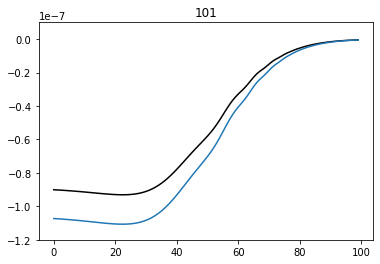

In [41]:
plt.plot(integral/dchi_binned**2 - 2 * cross, 'k')
plt.title(comb_n_external)
plt.plot(comb[:,0,0])
plt.ylim(-1.2e-7,1e-8)

In [31]:
comb_n_external = 301
comb_unbinned = np.zeros((len(ells), comb_n_external, comb_n_external))
for ell_idx in range(len(ells)):
    comb_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
    comb_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_l_%d_jax_quad.npy'%('CO',
                                                                                  zmin, zmax, 
                                                                                  Lambda_idx, 
                                                                                  comb_n_external,
                                                                                  ell_idx)


    comb_unbinned[ell_idx] = np.load(comb_fname)

comb = get_binned(comb_unbinned, n_external = comb_n_external)


In [34]:
asdfint = np.load(oup_fname)

(-1.2e-07, 1e-08)

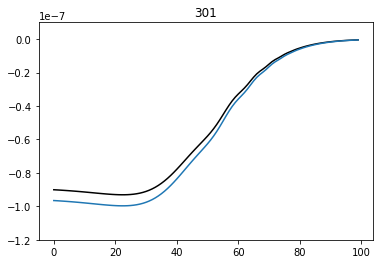

In [38]:
plt.plot(integral/dchi_binned**2 - 2 * cross, 'k')
plt.title(comb_n_external)
plt.plot(comb[:,0,0])
plt.ylim(-1.2e-7,1e-8)

In [33]:
# it looks like its converging to the qmc 